# Fashion MNIST using Linear Layers with JAX

- toc: true
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png



My main objective here is to develop a Keras like API for JAX, and use it on the so-called Fashion MNIST dataset.

In [723]:
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax 

from typing import Callable, List, NamedTuple


## Grabbing the Data

In [724]:
import tensorflow as tf

In [725]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [726]:

print(f'Number of training samples = {len(y_train)}') 
print(f'Number of test samples = {len(y_test)}')

Number of training samples = 60000
Number of test samples = 10000


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0   0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62  54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134 144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178 107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216 216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 232 233 229 223 22

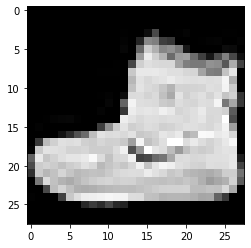

In [727]:
X = X_train[0]
np.set_printoptions(linewidth=200)
plt.imshow(X, cmap='gray')
print(X)

In [728]:
X_train, X_test = X_train / 255.0, X_test / 255.0

## Model API

In [753]:
class Function: 
    pass
class Model: 
    def forward(self, params, X, y):
        raise NotImplementedError
    def compile(self, loss, optimizer, metrics, params):
        self.loss = loss 
        self.optimizer = optimizer 
        self.metrics = metrics 
        self.params = params
    def fit(self, X_train, y_train):
        
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.shuffle(100).batch(32)
        
        loss = self.loss 
        optimizer = self.optimizer 
        params = self.params
        # Get the parameters from the model ...

        # Taken from optax tutorial code ...
        opt_state = self.optimizer.init(params)
        
        def step(params, opt_state, batch, labels):
            loss_value, grads = jax.value_and_grad(loss)(params, self.forward, batch, labels)
            updates, opt_state = optimizer.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            return params, opt_state, loss_value

        # one epoch
        for i, (batch, labels) in enumerate(train_dataset.as_numpy_iterator()):
            loss_value, _ = jax.value_and_grad(loss)(params, self.forward, batch, labels)
            params, opt_state, loss_value = step(params, opt_state, batch, labels)
            if i % 100 == 0:
                print(f'step {i}, loss: {loss_value}')

        
    

In [754]:
class Dense(Model):
    def __init__(self, num_features, activation=jax.nn.relu):
        self.num_features = num_features 
        self.activation = activation
    
    def setup(self, input_shape):
        self.input_shape = input_shape
        shape = (self.num_features, self.input_shape)
        key = jax.random.PRNGKey(1234)
        _params = {
            #'input_shape': input_shape,
            #'num_features': self.num_features,
            'weights': jax.random.normal(key, shape) * jnp.sqrt(2.0 / input_shape),
            'bias': jnp.zeros(self.num_features)
        }
        return _params 

    def forward(self, params, x):
        w, b = params['weights'], params['bias']
        return self.activation(jnp.dot(w, x) + b) 
    
    def __call__(self, x):
        return self.activation(jnp.dot(self.w, x) + self.b) 



In [755]:
l = Dense(10)
p = l.setup(input_shape=3)
l.forward(p, np.random.randn(3))

DeviceArray([0.        , 0.        , 0.        , 3.9159968 , 4.3758116 , 0.2836208 , 0.10902514, 0.        , 0.44189295, 1.9883591 ], dtype=float32)

In [756]:
class Flatten(Function):
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.num_features= np.prod(input_shape) 
    def setup(self, input_shape):
        self.input_shape = input_shape
        self.num_features = np.prod(input_shape)
    def __call__(self, x):
        assert jnp.shape(x) == self.input_shape, f'Shapes do not match'
        return jnp.reshape(x, -1)


In [757]:
class Sequential(Model):
    def __init__(self, *layers):
        self.layers = layers
    def setup(self, input_shape):
        self.input_shape = input_shape
        params = []
        input_shape = self.input_shape
        for layer in self.layers:
            if isinstance(layer, Model):
                params.append(layer.setup(input_shape))
                input_shape = layer.num_features
            elif isinstance(layer, Function): 
                #params.append({'input_dim': layer.input_shape, 'num_features': layer.num_features})
                input_shape = layer.num_features
        return params    
    def __call__(self, x):
        y = x
        for layer in self.layers:
            y = layer(x)
        return y
        
    def forward(self, params, x):
        y = x
        i = 0
        for layer in self.layers:
            if isinstance(layer, Model):
                y = layer.forward(params[i], y)
                i += 1 
            else:
                y = layer(y)
        return y

The type of model we're looking to build can be represented in Keras, as follows:

```python
model = keras.Sequential([
  keras.layers.Flatten(input_shape=(28,28)),
  keras.layers.Dense(128, activation=keras.activations.relu),
  keras.layers.Dense(10, activation=keras.activations.softmax)                          
])

model.compile(
    loss=keras.losses.sparse_categorical_crossentropy, 
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)
```

# How can we convert the following simple module into something usable, this is really just a specification ...

In [758]:
def MLP(x):
    x = Flatten()(x)
    x = Dense(128, activation=jax.nn.relu)(x)
    x = Dense(10)
    return x    

In [759]:

import inspect
inspect.getsource(MLP).split('\n')[1:-1]

['    x = Flatten()(x)',
 '    x = Dense(128, activation=jax.nn.relu)(x)',
 '    x = Dense(10)',
 '    return x    ']

## Loss Function

In [760]:
# parameters pulled from model, this seems really clunky ...
def cross_entropy_loss(params, forward, X, y):
    # Need to one-bot encode input labels, recall that MNIST has 10 classes, 0-9
    y_one_hot = jax.nn.one_hot(y, 10).astype(jnp.float32)
    logits = jax.vmap(forward, in_axes=(None, 0))(params, X) 
    # calculate loss for each sample in minibatch
    loss = optax.softmax_cross_entropy(logits, y_one_hot)
    # average the losses for each sample in minibatch
    loss = loss.mean() 
    return loss

In [761]:
model = Sequential(
    Flatten(input_shape=(28, 28)),
    Dense(128, activation=jax.nn.relu),
    Dense(10, activation = jax.nn.softmax)   
)

init_params = model.setup(input_shape=(28, 28))



In [762]:
model.forward(init_params, np.random.rand(28, 28))

DeviceArray([0.02157694, 0.09008522, 0.01330612, 0.14697005, 0.03000481, 0.31934047, 0.08668316, 0.07532562, 0.19995402, 0.01675361], dtype=float32)

In [763]:
cross_entropy_loss(init_params, model.forward, np.random.randn(2, 28, 28), [1, 2])

DeviceArray(2.388558, dtype=float32)

In [764]:

model.compile(loss=cross_entropy_loss, optimizer = optax.adam(learning_rate=1e-3), metrics = ['accuracy'], params=init_params)
model.fit(X_train, y_train)

step 0, loss: 2.3042030334472656
step 100, loss: 1.7702372074127197
step 200, loss: 1.8559722900390625
step 300, loss: 1.8455866575241089
step 400, loss: 1.6030317544937134
step 500, loss: 1.7808022499084473
step 600, loss: 1.7045600414276123
step 700, loss: 1.6650400161743164
step 800, loss: 1.6782312393188477
step 900, loss: 1.759960651397705
step 1000, loss: 1.7251852750778198
step 1100, loss: 1.7144274711608887
step 1200, loss: 1.5780982971191406
step 1300, loss: 1.5931434631347656
step 1400, loss: 1.7018799781799316
step 1500, loss: 1.7146620750427246
step 1600, loss: 1.6924097537994385
step 1700, loss: 1.626793622970581
step 1800, loss: 1.6654064655303955


## Training Loop

The training loop tunes the model parameters for a specified number of epochs.  For now the parameters are adjusted once per epoch, after the entire dataset is consumed by the model.  

## Performance Curve

Let's see the trend in the loss function.

## Conclusion



In [41]:
X = np.random.randn(10, 3)
w = np.random.randn(5, 3)

In [42]:
np.dot(X, np.transpose(w))

array([[ 0.95615652, -0.60910943,  0.47719404,  0.50628421, -0.57886369],
       [ 3.09498684,  1.70024379, -1.01957485,  2.25813896, -0.37952626],
       [-3.67871561, -0.1351104 ,  0.04294664, -1.84479421,  0.98852387],
       [-1.00596024,  0.46315551,  0.67104569,  3.13116358, -1.09329311],
       [ 2.07878921,  1.88358723, -1.42939824,  0.84352964,  0.39912581],
       [ 2.91327168, -1.07647233,  0.73089571,  1.0445742 , -1.1687821 ],
       [ 1.03321149,  0.51671102,  0.70734573,  4.30933842, -1.72017219],
       [-2.73799462, -1.54710401,  1.83484434,  1.17423297, -1.08464385],
       [-1.6715637 , -2.74092988,  1.91974295, -1.18807747, -0.68628707],
       [ 1.21170605,  0.15311168, -0.1815407 ,  0.30359954, -0.13915325]])

In [44]:
def lin(x): return jnp.dot(w, x)

yy = jax.vmap(lin)(X)
print(yy)

[[ 0.9561565  -0.6091094   0.47719404  0.50628424 -0.5788637 ]
 [ 3.0949867   1.7002438  -1.0195749   2.258139   -0.37952614]
 [-3.6787155  -0.13511032  0.04294658 -1.8447943   0.9885239 ]
 [-1.0059603   0.46315545  0.67104566  3.1311636  -1.093293  ]
 [ 2.0787892   1.8835871  -1.4293982   0.8435297   0.39912578]
 [ 2.9132717  -1.0764723   0.7308957   1.044574   -1.1687821 ]
 [ 1.0332114   0.516711    0.7073457   4.309338   -1.7201722 ]
 [-2.7379947  -1.547104    1.8348444   1.174233   -1.0846438 ]
 [-1.6715636  -2.7409298   1.919743   -1.1880776  -0.686287  ]
 [ 1.2117062   0.15311167 -0.1815407   0.3035995  -0.13915324]]
